In [88]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
housing = fetch_california_housing()


# 10 Поиск выбросов и генерация новых признаков

In [89]:
df = pd.read_csv('../../src/glass.csv')

In [90]:
df.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516522,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


In [91]:
for col in df.columns:
    if df[col].isnull().sum():
        raise print(f"из None column {col}", df[col].isnull().sum())

In [92]:
df['Type'].value_counts()

Type
2    76
1    70
7    29
3    17
5    13
6     9
Name: count, dtype: int64

### Разделение выборки `20` `80`

In [93]:
futures = ['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']

X = df[futures]
y = df['Type']
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.20, random_state=42)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(171, 9) (43, 9)
(171,) (43,)


### Обучение RandomForestClassifier без удаления выбросов и какой либо обработки

In [94]:
from sklearn.metrics import f1_score

rFC = RandomForestClassifier(n_estimators=1500, max_depth=5, random_state=0)
rFC.fit(X_train, y_train)
train_score = rFC.score(X_train, y_train)
test_score = rFC.score(X_test, y_test)
print(f"Глубина дерева: {5} | train_score: {train_score:.2f} test_score: {test_score:.2f} | delta: {(train_score - test_score):.2f}")

y_test_pred = rFC.predict(X_test)
f_1 = f1_score(y_test_pred, y_test, average=None)
count_class, f_1_, f_1_mean = len(f_1), [round(f, 2) for f in f_1], round(f_1.mean(), 2)
print(f"средний f-1 для {count_class} классов: {f_1_mean} при этом для каждого он составляет")
pd.Series(f_1).apply(lambda x: round(x, 2))

Глубина дерева: 5 | train_score: 0.91 test_score: 0.84 | delta: 0.08
средний f-1 для 6 классов: 0.8 при этом для каждого он составляет


0    0.85
1    0.79
2    0.50
3    0.67
4    1.00
5    1.00
dtype: float64

### Обработка выбросов

Text(0.5, 1.0, 'График выбросов')

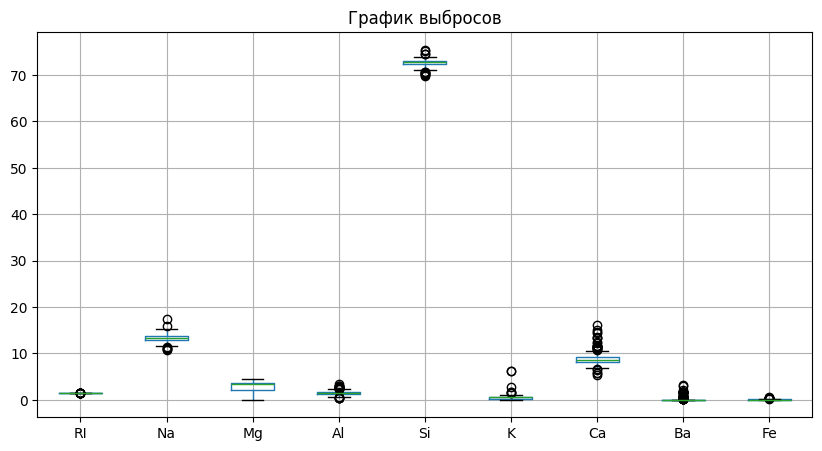

In [95]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
df[futures].boxplot(ax=axes).set_title("График выбросов")

#### Нормализация данных для более оптимальной оценки

Text(0.5, 1.0, 'График выбросов c использованием стандартизации данных')

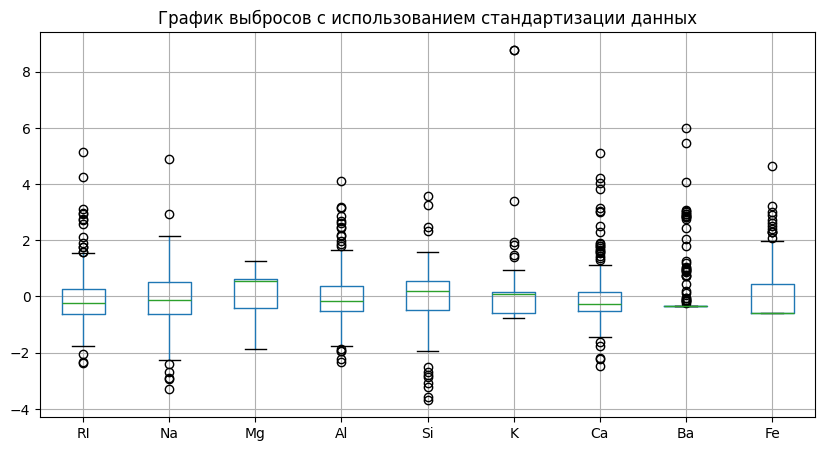

In [96]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(df[futures])
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
standard_df = pd.DataFrame(scaler.transform(df[futures]), columns=scaler.feature_names_in_)
standard_df.boxplot(ax=axes).set_title("График выбросов c использованием стандартизации данных")

In [97]:
print(f"{(len(X[abs(standard_df.RI) > 2]) / len(df)):.2f} % - удаленных строк с выбросами на основании усреднения данных")

0.06 % - удаленных строк с выбросами на основании усреднения данных


#### Обучение на данных после стандартизации и выброс которых больше 2 по модулю

In [98]:
X_train_stand, _, y_train_stand, _ =train_test_split(
    X[abs(standard_df.RI) < 2],
    y[abs(standard_df.RI) < 2],
    test_size=0.20, random_state=42)
rFC.fit(X_train_stand, y_train_stand)

train_score_out = rFC.score(X_train_stand, y_train_stand)
train_score = rFC.score(X_train, y_train)
test_score = rFC.score(X_test, y_test)
print(f"Глубина дерева: {5} | train_score_stand: {train_score_out:.2f} train_score: {train_score:.2f} test_score: {test_score:.2f} | delta: {(train_score - test_score):.2f}")

y_test_pred = rFC.predict(X_test)
f_1 = f1_score(y_test_pred, y_test, average=None)
count_class, f_1_, f_1_mean = len(f_1), [round(f, 2) for f in f_1], round(f_1.mean(), 2)
print(f"средний f-1 для {count_class} классов: {f_1_mean} при этом для каждого он составляет")
pd.Series(f_1).apply(lambda x: round(x, 2))

Глубина дерева: 5 | train_score_stand: 0.93 train_score: 0.86 test_score: 0.88 | delta: -0.02
средний f-1 для 6 классов: 0.85 при этом для каждого он составляет


0    0.88
1    0.85
2    0.50
3    0.89
4    1.00
5    1.00
dtype: float64

#### Метод удаления выбросов `DBSCAN` и обучение модели на очищенных данных

In [99]:
from sklearn.cluster import DBSCAN
DB = DBSCAN(eps=2.5, min_samples=25)
DB.fit(df[futures])

DBSCAN(eps=2.5, min_samples=25)

In [100]:
df['Db_'] = pd.Series(DB.labels_)
print(f"{(len(df[df['Db_'] == -1]) / len(df)):.2f} % - удаленных строк с выбросами на основании DBSCAN")

0.08 % - удаленных строк с выбросами на основании DBSCAN


In [101]:
X_train_DB, _, y_train_DB, _ =train_test_split(X[df['Db_'] != -1] , y[df['Db_'] != -1], test_size=0.20, random_state=42)

rFC.fit(X_train_DB, y_train_DB)
train_score_out = rFC.score(X_train_DB, y_train_DB)
train_score = rFC.score(X_train, y_train)
test_score = rFC.score(X_test, y_test)
print(f"Глубина дерева: {5} | train_score_DB: {train_score_out:.2f} train_score: {train_score:.2f} test_score: {test_score:.2f} | delta: {(train_score - test_score):.2f}")

y_test_pred = rFC.predict(X_test)
f_1 = f1_score(y_test_pred, y_test, average=None)
count_class, f_1_, f_1_mean = len(f_1), [round(f, 2) for f in f_1], round(f_1.mean(), 2)
print(f"средний f-1 для {count_class} классов: {f_1_mean} при этом для каждого он составляет")
pd.Series(f_1).apply(lambda x: round(x, 2))

Глубина дерева: 5 | train_score_DB: 0.92 train_score: 0.84 test_score: 0.91 | delta: -0.07
средний f-1 для 6 классов: 0.9 при этом для каждого он составляет


0    0.87
1    0.90
2    0.80
3    0.86
4    1.00
5    1.00
dtype: float64

#### Метод удаления выбросов `LocalOutlierFactor` и обучение модели на очищенных данных

In [102]:
from sklearn.neighbors import LocalOutlierFactor
LOF = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=0.1)

In [103]:
LOF.fit(df[futures])

LocalOutlierFactor(contamination=0.1, novelty=True)

In [104]:
df['LOF'] = pd.DataFrame(LOF.predict(df[futures]), columns=['LOF'])
print(f"{(len(df[df['LOF'] == -1]) / len(df)):.2f} % - удаленных строк с выбросами на основании LOF")

0.09 % - удаленных строк с выбросами на основании LOF


d:\avsip\code\ML\home_work_netology\.venv\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


In [105]:
X_train_LOF, _, y_train_LOF, _ =train_test_split(X[df['LOF'] != -1] , y[df['LOF'] != -1], test_size=0.20, random_state=42)

rFC.fit(X_train_LOF, y_train_LOF)
train_score_ = rFC.score(X_train_LOF, y_train_LOF)
train_score = rFC.score(X_train, y_train)
test_score = rFC.score(X_test, y_test)
print(f"Глубина дерева: {5} | {train_score_:.2f} train_score: {train_score:.2f} test_score: {test_score:.2f} | delta: {(train_score - test_score):.2f}")

y_test_pred = rFC.predict(X_test)
f_1 = f1_score(y_test_pred, y_test, average=None)
count_class, f_1_, f_1_mean = len(f_1), [round(f, 2) for f in f_1], round(f_1.mean(), 2)
print(f"средний f-1 для {count_class} классов: {f_1_mean} при этом для каждого он составляет")
pd.Series(f_1).apply(lambda x: round(x, 2))

Глубина дерева: 5 | 0.92 train_score: 0.85 test_score: 0.88 | delta: -0.03
средний f-1 для 6 классов: 0.87 при этом для каждого он составляет


0    0.88
1    0.86
2    0.80
3    0.86
4    0.80
5    1.00
dtype: float64

#### Метод удаления выбросов `IsolationForest` и обучение модели на очищенных данных

In [106]:
from sklearn.ensemble import IsolationForest

If = IsolationForest()
df['If'] = pd.DataFrame(If.fit_predict(df[futures]), columns=['If'])
print(f"{(len(df[df['If'] == -1]) / len(df)):.2f} % - удаленных строк с выбросами на основании If")

0.10 % - удаленных строк с выбросами на основании If


In [107]:
X_train_If, _, y_train_If, _ =train_test_split(X[df['If'] != -1] , y[df['If'] != -1], test_size=0.20, random_state=42)

rFC.fit(X_train_If, y_train_If)
train_score_ = rFC.score(X_train_If, y_train_If)
train_score = rFC.score(X_train, y_train)
test_score = rFC.score(X_test, y_test)
print(f"Глубина дерева: {5} | {train_score_:.2f} train_score: {train_score:.2f} test_score: {test_score:.2f} | delta: {(train_score - test_score):.2f}")

y_test_pred = rFC.predict(X_test)
f_1 = f1_score(y_test_pred, y_test, average=None)
count_class, f_1_, f_1_mean = len(f_1), [round(f, 2) for f in f_1], round(f_1.mean(), 2)
print(f"средний f-1 для {count_class} классов: {f_1_mean} при этом для каждого он составляет")
pd.Series(f_1).apply(lambda x: round(x, 2))

Глубина дерева: 5 | 0.92 train_score: 0.80 test_score: 0.88 | delta: -0.09
средний f-1 для 6 классов: 0.82 при этом для каждого он составляет


0    0.92
1    0.87
2    0.50
3    0.86
4    0.80
5    1.00
dtype: float64

### Сравнение параметров трех методов и обучить модель только на совпадениях по исключениям

In [108]:
def check(row):
    if row['Db_'] == row['LOF'] and row['Db_'] == row['If']:
        return -1
    return None

df['all'] = df.apply(lambda row : check(row), axis=1)
print(f"{(len(df[df['all'] == -1]) / len(df)):.2f} % - удаленных строк с выбросами на основании исключения если все три модели определили как выброс")

0.03 % - удаленных строк с выбросами на основании исключения если все три модели определили как выброс


In [109]:
X_train_all, _, y_train_all, _ =train_test_split(X[df['all'] != -1] , y[df['all'] != -1], test_size=0.20, random_state=42)

rFC.fit(X_train_all, y_train_all)
train_score_ = rFC.score(X_train_all, y_train_all)
train_score = rFC.score(X_train, y_train)
test_score = rFC.score(X_test, y_test)
print(f"Глубина дерева: {5} | {train_score_:.2f} train_score: {train_score:.2f} test_score: {test_score:.2f} | delta: {(train_score - test_score):.2f}")

y_test_pred = rFC.predict(X_test)
f_1 = f1_score(y_test_pred, y_test, average=None)
count_class, f_1_, f_1_mean = len(f_1), [round(f, 2) for f in f_1], round(f_1.mean(), 2)
print(f"средний f-1 для {count_class} классов: {f_1_mean} при этом для каждого он составляет")
pd.Series(f_1).apply(lambda x: round(x, 2))

Глубина дерева: 5 | 0.89 train_score: 0.80 test_score: 0.84 | delta: -0.04
средний f-1 для 6 классов: 0.8 при этом для каждого он составляет


0    0.81
1    0.81
2    0.50
3    0.86
4    0.80
5    1.00
dtype: float64

### Вывод

+ в данных есть выбросы, практически во всех параметрах, за исключением `Mg`
+ нормальное распределение не выявлено, есть либо выбросы или отклонение медианы в ту или иную сторону
  + без удаления выбросов: train_score: `0.91` test_score: `0.81`
+ Проделана следующие методы удаления выбросов:
  + `-0,06%` поиск после усреднения и отклонения более чем на значение 2 (определил по графику, как границу усов) train_score: `0.87` test_score: `0.88`
  + ✔✔✔ `-0.08 %` `DBSCAN` - train_score: `0.84` test_score: `0.91` средний `f-1` для `6` классов: `0.9`
  + `-0.09 %` `LOF` - train_score: `0.84` test_score: `0.86`
  + `-0.11 %` `IsolationForest` - train_score: `0.82` test_score: `0.88`
  + `-0.03 %` как совпадение трех моделей по выбросам - train_score: `0.81` test_score: `0.86` средний `f-1` для `6` классов: `0.8`

**Без удаления выбросов модель показала худший результат**
**метод DBSCAN показал самый лучший результат, при этом удалил оптимальное количество данных**

+ Важно отметить, что удаление выбросов вручную очень трудоемко, хотя и дает не плохие результаты, но сопряжено с рисками некорректной оценки
+ Использование методов моделей, значительно упрощает процесс и позволяет настраивать параметры для обеспечения контроля данного процесса
+ Цель данного подхода заключается в подготовке данных, максимально корректно описывающих реальное поведение исследуемых признаков в жизни, без учета случайностей